In [25]:
# import necessary packages
import skimage
from skimage import measure
import pandas as pd
import numpy as np
import os, sys
import argparse
import time
import cv2
import math
import tqdm.notebook as tqdm
import matplotlib
import matplotlib.pyplot as plt


from multiprocessing import Pool
from PIL import Image

sys.path.append('../')

# custom
from utils.GetFileNames import get_file_names

In [2]:
# load measurements.py
measurements = pd.read_csv('../data/pop_scale/pop_scale_segmentations_measurements/measurements.csv')

# remove all rows with wing area < .2 (outliers)
measurements = measurements[measurements["wing area"] > .2]
measurements.head()

,image_name,seed_count,wing area,env area,seed area
2,pred_862-ref-ISU_002-rep_1-W-CORE_2.png,12,0.986468,0.347347,0.146899
3,pred_862-ref-ISU_002-rep_1-W-CORE_3.png,12,0.953851,0.328243,0.141648
4,pred_862-ref-ISU_002-rep_1-W-CORE_4.png,12,1.013385,0.313852,0.146003
5,pred_862-ref-ISU_002-rep_1-W-CORE_5.png,9,0.931091,0.308906,0.132562
6,pred_862-ref-ISU_002-rep_1-W-CORE_6.png,8,0.851342,0.327508,0.123190


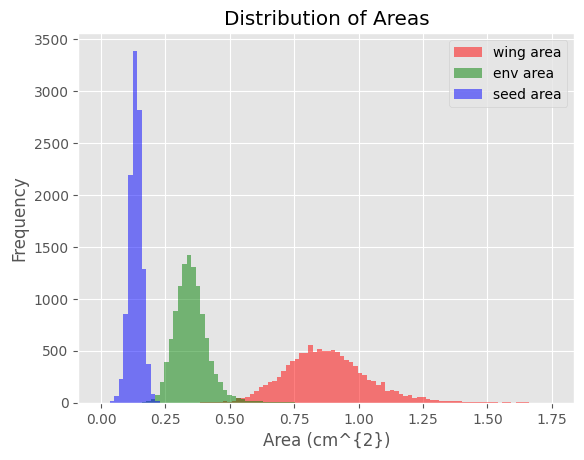

In [3]:
# plot distribution of tissue areas to check for outliers
with plt.style.context('ggplot'):
    plt.hist(measurements["wing area"], bins=100, range=(0, 1.75), label = "wing area", color = "red", alpha = 0.5);
    plt.hist(measurements["env area"], bins=100, range=(0, 1.75), label = "env area", color = "green", alpha = 0.5);
    plt.hist(measurements["seed area"], bins=100, range=(0, 1.75), label = "seed area", color = "blue", alpha = 0.5);
    plt.xlabel("Area (cm^{2})")
    plt.ylabel("Frequency")
    plt.title("Distribution of Areas")
    plt.legend()
    plt.show()

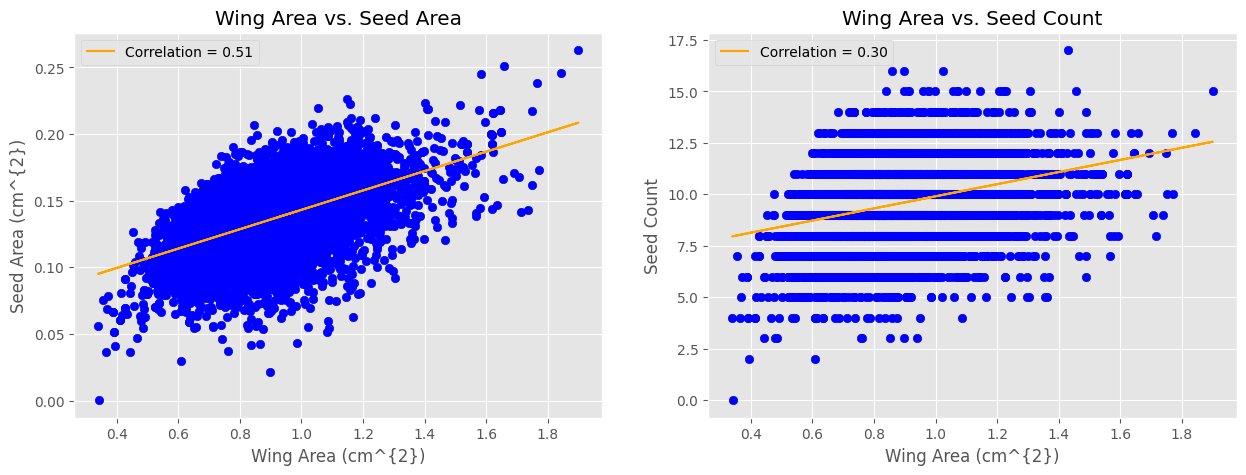

In [4]:
# plot correlations for averages
# get lines of best fit for wing area vs. seed area and seed count
area_slope, area_intercept = np.polyfit(measurements["wing area"], measurements["seed area"], 1)
count_slope, count_intercept = np.polyfit(measurements["wing area"], measurements["seed_count"], 1)

area_pearson = np.corrcoef(measurements["wing area"], measurements["seed area"])[0, 1]
count_pearson = np.corrcoef(measurements["wing area"], measurements["seed_count"])[0, 1]

# plot wing area vs. seed area and seed count
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].scatter(measurements["wing area"], measurements["seed area"], color = "blue")
    ax[0].plot(measurements["wing area"], 
               area_slope * measurements["wing area"] + area_intercept, 
               color = "orange",
               label = f"Correlation = {area_pearson:.2f}")
    ax[0].set_xlabel("Wing Area (cm^{2})")
    ax[0].set_ylabel("Seed Area (cm^{2})")
    ax[0].legend()
    ax[0].set_title("Wing Area vs. Seed Area")

    ax[1].scatter(measurements["wing area"], measurements["seed_count"], color = "blue")
    ax[1].plot(measurements["wing area"], 
               count_slope * measurements["wing area"] + count_intercept, 
               color = "orange",
               label = f"Correlation = {count_pearson:.2f}")
    ax[1].set_xlabel("Wing Area (cm^{2})")
    ax[1].set_ylabel("Seed Count")
    ax[1].legend()
    ax[1].set_title("Wing Area vs. Seed Count")

    plt.show()

In [5]:
# get average areas per genotype
measurements["genotype"] = [name[:-6] for name in measurements["image_name"]]

groupby = measurements.groupby("genotype")
avg_measurements = pd.DataFrame({'avg_wing_area': groupby["wing area"].mean(),
                                 'avg_env_area': groupby["env area"].mean(),
                                 'avg_seed_area': groupby["seed area"].mean(),
                                 'avg_seed_count': groupby["seed_count"].mean(),
                                 'genotype': groupby["genotype"].first()})
avg_measurements.head()

,avg_wing_area,avg_env_area,avg_seed_area,avg_seed_count,genotype
genotype,,,,,
pred_1.tt8t x fc6-1.B.WBP-2022.W,1.035435,0.331851,0.155475,9.2,pred_1.tt8t x fc6-1.B.WBP-2022.W
pred_10.tt8t x fc5-2.B.WBP-2022.W,1.161073,0.400954,0.147018,9.3,pred_10.tt8t x fc5-2.B.WBP-2022.W
pred_100.ISU397_A.B.ISU Wild.S,0.856427,0.280958,0.101233,7.7,pred_100.ISU397_A.B.ISU Wild.S
pred_101.ISU398_A.B.ISU Wild.W,0.623864,0.342791,0.114140,7.5,pred_101.ISU398_A.B.ISU Wild.W
pred_102.ISU399_A.B.ISU Wild.W,0.857869,0.297062,0.119175,8.0,pred_102.ISU399_A.B.ISU Wild.W


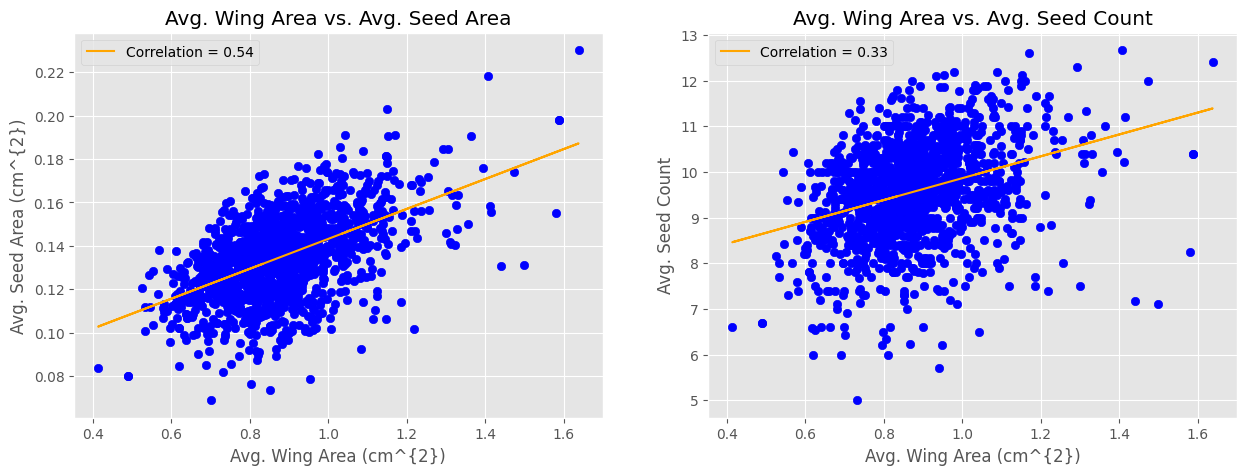

In [6]:
# plot correlations for averages
# get lines of best fit for wing area vs. seed area and seed count
area_slope, area_intercept = np.polyfit(avg_measurements["avg_wing_area"], avg_measurements["avg_seed_area"], 1)
count_slope, count_intercept = np.polyfit(avg_measurements["avg_wing_area"], avg_measurements["avg_seed_count"], 1)

area_pearson = np.corrcoef(avg_measurements["avg_wing_area"], avg_measurements["avg_seed_area"])[0, 1]
count_pearson = np.corrcoef(avg_measurements["avg_wing_area"], avg_measurements["avg_seed_count"])[0, 1]

# plot wing area vs. seed area and seed count
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].scatter(avg_measurements["avg_wing_area"], avg_measurements["avg_seed_area"], color = "blue")
    ax[0].plot(avg_measurements["avg_wing_area"], 
               area_slope * avg_measurements["avg_wing_area"] + area_intercept, 
               color = "orange",
               label = f"Correlation = {area_pearson:.2f}")
    ax[0].set_xlabel("Avg. Wing Area (cm^{2})")
    ax[0].set_ylabel("Avg. Seed Area (cm^{2})")
    ax[0].legend()
    ax[0].set_title("Avg. Wing Area vs. Avg. Seed Area")

    ax[1].scatter(avg_measurements["avg_wing_area"], avg_measurements["avg_seed_count"], color = "blue")
    ax[1].plot(avg_measurements["avg_wing_area"], 
               count_slope * avg_measurements["avg_wing_area"] + count_intercept, 
               color = "orange",
               label = f"Correlation = {count_pearson:.2f}")
    ax[1].set_xlabel("Avg. Wing Area (cm^{2})")
    ax[1].set_ylabel("Avg. Seed Count")
    ax[1].legend()
    ax[1].set_title("Avg. Wing Area vs. Avg. Seed Count")

    plt.show()

In [7]:
# specify input / output directories
img_path = '../data/train/train_images_by_pod/'
seg_path = '../data/train/train_masks_by_pod/'

# Get segmentations filenames
img_names = get_file_names(img_path, '.png')
print('Number of segmentations:', len(img_names))

seg_names = get_file_names(seg_path, '.png')
print('Number of segmentations:', len(seg_names))

Number of segmentations: 281
Number of segmentations: 281


In [8]:
img_names[0], seg_names[0]

('25.tt8t x fc5.B.WBP-2023.W_0.png', '25.tt8t x fc5.B.WBP-2023.W_0.png')

In [9]:
test_image = Image.open(img_path + img_names[0])
test_image = np.array(test_image)

test_mask = np.array(Image.open(seg_path + seg_names[0]))

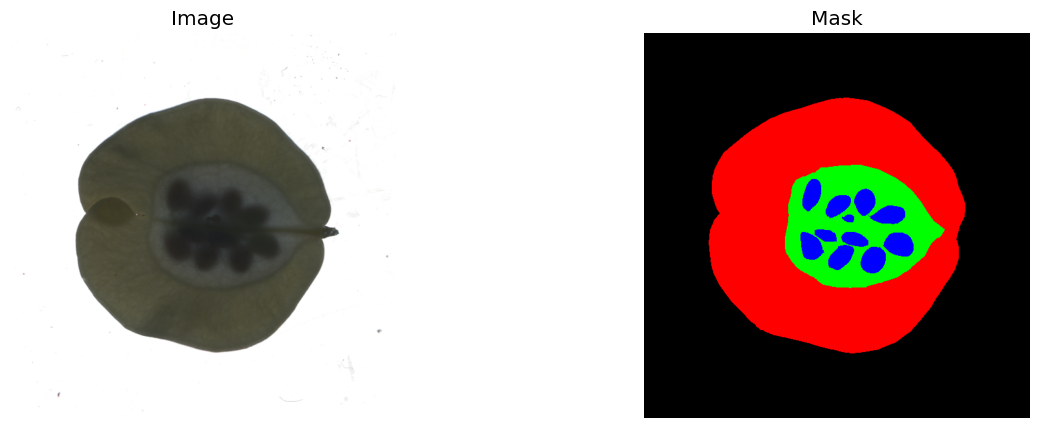

In [10]:
# plot test image and mask
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(test_image)
    ax[0].set_title("Image")
    ax[0].axis('off')

    ax[1].imshow(test_mask)
    ax[1].set_title("Mask")
    ax[1].axis('off')

    plt.show()

In [15]:
# get_color_features function
def get_color_features(img, mask):
    """
    Extracts color features from an image (r, g, b, h, s, v, l, a, B).

    Parameters:
        Image (np.array): An 3-channel image with range 0-255.
        Mask (np.array): A 3-channel mask with range 0-255.
    
    Returns:
        Features (tuple): A 3-object tuple, each containing a 9-dim feature vector with each object representing a color trait.
    """
    # get rgb, hsv, and lab color spaces
    rgb = img
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    r, g, b = rgb.astype(float).transpose(2, 0, 1)
    h, s, v = hsv.astype(float).transpose(2, 0, 1)
    l, a, B = lab.astype(float).transpose(2, 0, 1)

    # extract color features for segmentation classes
    # concat all feature maps into a tensor, index in with class label mask
    features = np.stack([r, g, b, h, s, v, l, a, B], axis=-1)

    # separate out the classes
    wing = test_mask[:,:,0] > 128
    env = test_mask[:,:,1] > 128
    seed = test_mask[:,:,2] > 128 

    # get features by class
    wing_features = features[wing] # output is (n_pixels, n_features)
    env_features = features[env]
    seed_features = features[seed]

    # aggregate features into phenotypes
    wing_phenotype = wing_features.mean(axis=0)
    env_phenotype = env_features.mean(axis=0)
    seed_phenotype = seed_features.mean(axis=0)

    return (wing_phenotype, env_phenotype, seed_phenotype)


array([ 76.59266367,  76.66958763,  60.24729194,  31.53321927,
        58.22178934,  77.27232055,  81.80275373, 124.76688131,
       137.84170125])

In [20]:
test_wp, test_ep, test_sp = get_color_features(test_image, test_mask)

In [26]:
# perimeter function
def perimeter(mask):

    """
    Calculates the perimeter of a multiclass mask.

    Parameters:
        Mask (np.array): A 3-channel mask with range 0-255.

    Returns: 
        Perimeter (tuple): A 3-object tuple, each containing the perimeter of the mask.
    """

    # separate out the classes
    wing = mask[:,:,0] > 128
    env = mask[:,:,1] > 128
    seed = mask[:,:,2] > 128

    # get perimeters by class
    wing_perimeter = measure.perimeter(wing + env + seed)
    env_perimeter = measure.perimeter(env + seed)
    seed_perimeter = measure.perimeter(seed)

    return (wing_perimeter, env_perimeter, seed_perimeter)

In [27]:
wp, ep, sp = perimeter(test_mask)


In [34]:
def to_total_ratio(mask, feature: str, type: str = "area"):

    """
    Calculates the ratio of a feature to the total area of a mask.

    Parameters:
        Mask (np.array): A 3-channel mask with range 0-255.
        Feature (str): The feature to calculate the ratio of.
        Type (str): The type of feature to calculate the ratio of. Must be one of 'area' or 'perimeter.'

    Returns:
        Ratio (float): The ratio of the feature to the total area of the mask.
    """

    assert feature in ["wing", "env", "seed"], "Feature must be one of 'wing', 'env', or 'seed'."
    assert type in ["area", "perimeter"], "Type must be one of 'area' or 'perimeter'."

    if type == "area":
        # separate out the classes
        wing = mask[:,:,0] > 128
        env = mask[:,:,1] > 128
        seed = mask[:,:,2] > 128

        # get areas by class
        wing_area, env_area, seed_area = wing.sum(), env.sum(), seed.sum()

        # get total area
        total_area = wing_area + env_area + seed_area

        # get ratio of feature to total area
        if feature == "wing":
            return wing_area / total_area
        elif feature == "env":
            return env_area / total_area
        elif feature == "seed":
            return seed_area / total_area
    
    elif type == "perimeter":
        # get perimeters by class
        wing_perimeter, env_perimeter, seed_perimeter = perimeter(mask)

        # get total perimeter
        total_perimeter = wing_perimeter + env_perimeter + seed_perimeter

        # get ratio of feature to total perimeter
        if feature == "wing":
            return wing_perimeter / total_perimeter
        elif feature == "env":
            return env_perimeter / total_perimeter
        elif feature == "seed":
            return seed_perimeter / total_perimeter

In [35]:
# get ratios
features = ["wing", "env", "seed"]
area_ratios = [to_total_ratio(test_mask, feature, type = "area") for feature in features]
perimeter_ratios = [to_total_ratio(test_mask, feature, type = "perimeter") for feature in features]

area_ratios, perimeter_ratios

([0.7123293311593129, 0.20292504570383912, 0.084745623136848],
 [0.39739724909618507, 0.21751250236068026, 0.3850902485431347])

In [36]:
sum(area_ratios), sum(perimeter_ratios)

(1.0, 1.0)

In [ ]:
# write a function to calculate ratio features between two classes
def between_ratio(mask, feature1: str, feature2: str, type: str = "area"):

    """
    Calculates the ratio of a feature between two classes.

    Parameters:
        mask (np.array): A 3-channel mask with range 0-255.
        feature1 (str): The first feature to calculate the ratio between.
        feature2 (str): The second feature to calculate the ratio between.
        type (str): The type of feature to calculate the ratio of. Must be one of 'area' or 'perimeter.'
    
    Returns:
        Ratio (float): The ratio of the feature between the two classes. Calculated as feature1 / feature2.
    """

    # make sure the strings passed are valid
    assert feature1 and feature2 in ["wing", "env", "seed"], "Features must be one of 'wing', 'env', or 'seed'."
    assert type in ["area", "perimeter"], "Type must be one of 'area' or 'perimeter'."
    
    # define


    if type == "area":

        # separate out the classes
        wing = mask[:,:,0] > 128
        env = mask[:,:,1] > 128
        seed = mask[:,:,2] > 128

        # get areas by class
        wing_area, env_area, seed_area = wing.sum(), env.sum(), seed.sum()

        # get ratio of feature between two classes


    elif type == "perimeter":
        
        # get perimeters by class
        wing_perimeter, env_perimeter, seed_perimeter = perimeter(mask)
        # get ratio of feature between two classes
        
